In [11]:
import numpy as np
import torch
import os
import glob
import torchvision.transforms as transforms
import torchvision
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class MyDataset(Dataset):
    def __init__(self, npy_dir,tfms=None):
        self.dir_path = npy_dir
        self.to_tensor = transforms.ToTensor()

        # all npy path
        self.npy_path = glob.glob(os.path.join(npy_dir, '*','*.npy')) 
        self.tfms = tfms
    def __getitem__(self, index):
        # load data
        single_data_path = self.npy_path[index]
        data = np.load(single_data_path, allow_pickle=True)
        
        image = Image.fromarray(data[0])
        if self.tfms:
            image = self.tfms(image)
        else:
            image = self.to_tensor(image)
        label = data[1]
       
        return (image, label)

    def __len__(self):
        return len(self.npy_path)


trtfm = transforms.Compose([
                    
                    transforms.RandomRotation(degrees=(-10, 10),fill=1),
                    transforms.ToTensor(),
                    transforms.Normalize((0.6647), (0.73155)),
                    
                    ])
tttfm = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.6647), (0.73155))])

# load dataset 
train_data = MyDataset("./Font_npy_90_train",trtfm)
valid_data = MyDataset("./Font_npy_90_val",tttfm)



In [12]:
def train(model, train_loader, optimizer, criterion):
    epoch_loss, acc = 0, 0
    total = 0
    model.train()

    for i, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)

        out = model(image)
        loss = criterion(out, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        _, pred = torch.max(out.data, 1)
        acc += (pred==label).sum()
        epoch_loss += loss.item()
        total += float(len(image))

    return epoch_loss, acc /total

def valid(model, data_loader, criterion):
    epoch_loss, acc = 0, 0
    total = 0
    model.eval()

    with torch.no_grad():
        for i, (image, label) in enumerate(data_loader):
            image = image.to(device)
            label = label.to(device)

            out = model(image)
            loss = criterion(out, label)
            _, pred = torch.max(out.data, 1)
            acc += (pred==label).sum()
            epoch_loss += loss.item()
            total += float(len(image))

    return epoch_loss, acc /total

In [13]:
class MyNet(nn.Module):

    def __init__(self, block, layers, num_classe):
        super(MyNet, self).__init__()
        self._norm_layer = nn.BatchNorm2d

        self.dilation = 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=7, stride=2, padding=3,
                               bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)

        
        self.downsample1 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(64),
            )
        self.downsample2 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(128),
            )
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(4608, num_classe)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        ident = self.downsample1(x)
        x = self.conv2(x)
        x = self.bn2(x) + ident
        x = self.relu2(x)
        ident = self.downsample2(x)
        x = self.conv3(x)
        x = self.bn3(x) + ident
        x = self.relu3(x)
        
        x = torch.flatten(x,1)
#         print(x.shape)
        x = self.dropout(x)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


In [14]:
import time, tqdm
batch_size = 512
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size=batch_size,
                                           )

model4 = MyNet(None, [1,1],52)
model4.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=0.002)

num_epochs = 80
best_valid_loss = float('inf')
best_epoch = 0
start = time.time()
trl = []
tra = []
vall =[]
vala = []
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
for epoch in tqdm.tqdm(range(num_epochs)):
    train_loss, train_acc = train(model4, train_loader, optimizer, criterion)
    valid_loss, valid_acc = valid(model4,valid_loader, criterion)
    trl.append(train_loss)
    tra.append(train_acc)
    vall.append(valid_loss)
    vala.append(valid_acc)
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         best_epoch = epoch
#         torch.save(model.state_dict(), "./epoch_{}.pth".format(epoch))

    print("Epoch[{}/{}], Train Loss:{:.4f}, Train Acc:{:.2f}".format(epoch+1, num_epochs, train_loss, train_acc))
    print(valid_loss, valid_acc)
#     if valid_acc > 0.9620:
#         torch.save(model4.state_dict(), "./epoch_{}.pth".format(epoch))
end = time.time()
end-start
# 구글 vs 내컴 : 280 -> 195
# 경량화 모델 : 93.5 valid
# 16으로 줄였을때 : 93 valid
# 32으로 줄였을때 : 95.38 valid
# 32에서 128block 하나 추가했을 때 : 0.9590
# 32에서 128block,256block 두개 추가했을 때 : 0.9590

# 32에서 128block 하나 추가했을 때 + dropout(0.3) : 도달속도epoch 0.9368, 최고 0.9606
# 32에서 128block 하나 추가했을 때 + dropout + regularizer  : 96.04
# 32에서 128block 하나 추가했을 때 + dropout(0.2) : 도달속도 epcoh5 0.9362 최고 


# 32에서 128block 하나 추가했을 때 + dropout : 0.9606 모델 0.001 vs 0.005 vs 0.002 vs 0.0005 -> 0.002 이 더 빠름
# resnet 1,1은 너무 느림

  1%|▏         | 1/80 [00:27<35:59, 27.34s/it]

Epoch[1/80], Train Loss:66.6886, Train Acc:0.78
6.775733940303326 tensor(0.9015, device='cuda:0')


  2%|▎         | 2/80 [00:54<35:31, 27.33s/it]

Epoch[2/80], Train Loss:27.7925, Train Acc:0.90
5.914015024900436 tensor(0.9122, device='cuda:0')


  4%|▍         | 3/80 [01:22<35:04, 27.33s/it]

Epoch[3/80], Train Loss:21.7831, Train Acc:0.92
4.535429164767265 tensor(0.9278, device='cuda:0')


  5%|▌         | 4/80 [01:49<34:43, 27.41s/it]

Epoch[4/80], Train Loss:17.9348, Train Acc:0.93
4.025075811892748 tensor(0.9412, device='cuda:0')


  6%|▋         | 5/80 [02:17<34:20, 27.47s/it]

Epoch[5/80], Train Loss:15.6359, Train Acc:0.94
4.075694173574448 tensor(0.9417, device='cuda:0')


  8%|▊         | 6/80 [02:44<33:55, 27.51s/it]

Epoch[6/80], Train Loss:14.4087, Train Acc:0.94
3.538475861772895 tensor(0.9437, device='cuda:0')


  9%|▉         | 7/80 [03:11<33:21, 27.41s/it]

Epoch[7/80], Train Loss:13.3652, Train Acc:0.95
3.167108938097954 tensor(0.9483, device='cuda:0')


 10%|█         | 8/80 [03:39<32:51, 27.39s/it]

Epoch[8/80], Train Loss:11.7559, Train Acc:0.95
3.0668698586523533 tensor(0.9504, device='cuda:0')


 11%|█▏        | 9/80 [04:06<32:25, 27.40s/it]

Epoch[9/80], Train Loss:11.1128, Train Acc:0.96
3.151340251788497 tensor(0.9532, device='cuda:0')


 12%|█▎        | 10/80 [04:34<31:58, 27.41s/it]

Epoch[10/80], Train Loss:10.2594, Train Acc:0.96
3.0025892946869135 tensor(0.9527, device='cuda:0')


 14%|█▍        | 11/80 [05:01<31:31, 27.41s/it]

Epoch[11/80], Train Loss:10.0245, Train Acc:0.96
3.065097436308861 tensor(0.9533, device='cuda:0')


 15%|█▌        | 12/80 [05:28<31:04, 27.41s/it]

Epoch[12/80], Train Loss:9.3364, Train Acc:0.96
3.068132412619889 tensor(0.9526, device='cuda:0')


 16%|█▋        | 13/80 [05:56<30:35, 27.39s/it]

Epoch[13/80], Train Loss:8.8444, Train Acc:0.96
2.6878916416317225 tensor(0.9569, device='cuda:0')


 18%|█▊        | 14/80 [06:23<30:09, 27.41s/it]

Epoch[14/80], Train Loss:8.7480, Train Acc:0.96
3.010805381461978 tensor(0.9562, device='cuda:0')


 19%|█▉        | 15/80 [06:51<29:44, 27.46s/it]

Epoch[15/80], Train Loss:8.2373, Train Acc:0.97
3.016680721193552 tensor(0.9509, device='cuda:0')


 20%|██        | 16/80 [07:18<29:18, 27.47s/it]

Epoch[16/80], Train Loss:7.8636, Train Acc:0.97
2.8451447188854218 tensor(0.9562, device='cuda:0')


 21%|██▏       | 17/80 [07:46<28:50, 27.47s/it]

Epoch[17/80], Train Loss:7.7864, Train Acc:0.97
2.6576433572918177 tensor(0.9564, device='cuda:0')


 22%|██▎       | 18/80 [08:13<28:21, 27.45s/it]

Epoch[18/80], Train Loss:7.5042, Train Acc:0.97
3.112610657699406 tensor(0.9550, device='cuda:0')


 24%|██▍       | 19/80 [08:41<27:54, 27.44s/it]

Epoch[19/80], Train Loss:7.6907, Train Acc:0.97
2.6909466749057174 tensor(0.9592, device='cuda:0')


 25%|██▌       | 20/80 [09:08<27:27, 27.45s/it]

Epoch[20/80], Train Loss:7.0685, Train Acc:0.97
2.5237384103238583 tensor(0.9588, device='cuda:0')


 26%|██▋       | 21/80 [09:36<27:12, 27.67s/it]

Epoch[21/80], Train Loss:6.7958, Train Acc:0.97
2.6694387942552567 tensor(0.9568, device='cuda:0')


 28%|██▊       | 22/80 [10:04<26:46, 27.70s/it]

Epoch[22/80], Train Loss:6.7399, Train Acc:0.97
2.59392034355551 tensor(0.9581, device='cuda:0')


 29%|██▉       | 23/80 [10:32<26:17, 27.67s/it]

Epoch[23/80], Train Loss:6.8996, Train Acc:0.97
2.6499884109944105 tensor(0.9597, device='cuda:0')


 30%|███       | 24/80 [10:59<25:48, 27.65s/it]

Epoch[24/80], Train Loss:6.4145, Train Acc:0.97
2.436101868748665 tensor(0.9603, device='cuda:0')


 31%|███▏      | 25/80 [11:27<25:24, 27.72s/it]

Epoch[25/80], Train Loss:6.3137, Train Acc:0.97
2.3834084598347545 tensor(0.9606, device='cuda:0')


 32%|███▎      | 26/80 [11:55<24:57, 27.73s/it]

Epoch[26/80], Train Loss:6.0061, Train Acc:0.97
2.6512882113456726 tensor(0.9595, device='cuda:0')


 34%|███▍      | 27/80 [12:22<24:18, 27.51s/it]

Epoch[27/80], Train Loss:6.0931, Train Acc:0.97
2.415182551369071 tensor(0.9614, device='cuda:0')


 35%|███▌      | 28/80 [12:49<23:43, 27.38s/it]

Epoch[28/80], Train Loss:5.9742, Train Acc:0.97
2.637335111387074 tensor(0.9595, device='cuda:0')


 36%|███▋      | 29/80 [13:16<23:11, 27.29s/it]

Epoch[29/80], Train Loss:5.9900, Train Acc:0.97
2.4753705067560077 tensor(0.9599, device='cuda:0')


 38%|███▊      | 30/80 [13:44<22:48, 27.36s/it]

Epoch[30/80], Train Loss:5.9385, Train Acc:0.98
2.5792654175311327 tensor(0.9597, device='cuda:0')


 39%|███▉      | 31/80 [14:11<22:21, 27.37s/it]

Epoch[31/80], Train Loss:5.9181, Train Acc:0.98
2.472134428098798 tensor(0.9597, device='cuda:0')


 40%|████      | 32/80 [14:38<21:54, 27.39s/it]

Epoch[32/80], Train Loss:6.0026, Train Acc:0.97
2.553220615722239 tensor(0.9599, device='cuda:0')


 41%|████▏     | 33/80 [15:06<21:27, 27.40s/it]

Epoch[33/80], Train Loss:5.7863, Train Acc:0.97
2.53395330067724 tensor(0.9567, device='cuda:0')


 42%|████▎     | 34/80 [15:33<21:02, 27.45s/it]

Epoch[34/80], Train Loss:5.4898, Train Acc:0.98
2.579967537894845 tensor(0.9600, device='cuda:0')


 44%|████▍     | 35/80 [16:01<20:36, 27.48s/it]

Epoch[35/80], Train Loss:5.4384, Train Acc:0.98
2.68306224886328 tensor(0.9601, device='cuda:0')


 45%|████▌     | 36/80 [16:28<20:09, 27.49s/it]

Epoch[36/80], Train Loss:5.7305, Train Acc:0.98
2.53456794610247 tensor(0.9600, device='cuda:0')


 46%|████▋     | 37/80 [16:56<19:47, 27.61s/it]

Epoch[37/80], Train Loss:5.6677, Train Acc:0.98
2.440634203143418 tensor(0.9600, device='cuda:0')


 48%|████▊     | 38/80 [17:24<19:21, 27.66s/it]

Epoch[38/80], Train Loss:5.1000, Train Acc:0.98
2.4641570849344134 tensor(0.9601, device='cuda:0')


 49%|████▉     | 39/80 [17:52<18:53, 27.64s/it]

Epoch[39/80], Train Loss:5.0760, Train Acc:0.98
2.4709925381466746 tensor(0.9600, device='cuda:0')


 50%|█████     | 40/80 [18:19<18:25, 27.63s/it]

Epoch[40/80], Train Loss:5.2421, Train Acc:0.98
2.606430470943451 tensor(0.9621, device='cuda:0')


 51%|█████▏    | 41/80 [18:47<17:56, 27.60s/it]

Epoch[41/80], Train Loss:5.0114, Train Acc:0.98
2.512842277996242 tensor(0.9605, device='cuda:0')


 52%|█████▎    | 42/80 [19:14<17:27, 27.57s/it]

Epoch[42/80], Train Loss:4.9731, Train Acc:0.98
2.4414936343673617 tensor(0.9629, device='cuda:0')


 54%|█████▍    | 43/80 [19:42<16:59, 27.55s/it]

Epoch[43/80], Train Loss:5.0170, Train Acc:0.98
2.414408848620951 tensor(0.9614, device='cuda:0')


 55%|█████▌    | 44/80 [20:09<16:30, 27.50s/it]

Epoch[44/80], Train Loss:4.9336, Train Acc:0.98
2.5860792538151145 tensor(0.9618, device='cuda:0')


 56%|█████▋    | 45/80 [20:37<16:03, 27.52s/it]

Epoch[45/80], Train Loss:4.9157, Train Acc:0.98
2.4633237002417445 tensor(0.9621, device='cuda:0')


 57%|█████▊    | 46/80 [21:04<15:36, 27.53s/it]

Epoch[46/80], Train Loss:4.8267, Train Acc:0.98
2.4414752004668117 tensor(0.9612, device='cuda:0')


 59%|█████▉    | 47/80 [21:32<15:11, 27.61s/it]

Epoch[47/80], Train Loss:4.8130, Train Acc:0.98
2.5012519443407655 tensor(0.9613, device='cuda:0')


 60%|██████    | 48/80 [22:00<14:44, 27.63s/it]

Epoch[48/80], Train Loss:4.7997, Train Acc:0.98
2.65440391888842 tensor(0.9596, device='cuda:0')


 61%|██████▏   | 49/80 [22:27<14:17, 27.65s/it]

Epoch[49/80], Train Loss:4.8331, Train Acc:0.98
2.447299857158214 tensor(0.9619, device='cuda:0')


 62%|██████▎   | 50/80 [22:55<13:48, 27.63s/it]

Epoch[50/80], Train Loss:4.9957, Train Acc:0.98
2.4149060738272965 tensor(0.9631, device='cuda:0')


 64%|██████▍   | 51/80 [23:23<13:21, 27.64s/it]

Epoch[51/80], Train Loss:4.7079, Train Acc:0.98
2.3145126793533564 tensor(0.9615, device='cuda:0')


 65%|██████▌   | 52/80 [23:50<12:53, 27.63s/it]

Epoch[52/80], Train Loss:4.7358, Train Acc:0.98
2.52470616158098 tensor(0.9629, device='cuda:0')


 66%|██████▋   | 53/80 [24:18<12:24, 27.59s/it]

Epoch[53/80], Train Loss:4.8606, Train Acc:0.98
2.521777327405289 tensor(0.9638, device='cuda:0')


 68%|██████▊   | 54/80 [24:45<11:54, 27.47s/it]

Epoch[54/80], Train Loss:4.6623, Train Acc:0.98
2.429478914476931 tensor(0.9604, device='cuda:0')


 69%|██████▉   | 55/80 [25:12<11:23, 27.36s/it]

Epoch[55/80], Train Loss:4.5570, Train Acc:0.98
2.489248109050095 tensor(0.9619, device='cuda:0')


 70%|███████   | 56/80 [25:39<10:54, 27.27s/it]

Epoch[56/80], Train Loss:4.5363, Train Acc:0.98
2.439066652674228 tensor(0.9626, device='cuda:0')


 71%|███████▏  | 57/80 [26:07<10:28, 27.32s/it]

Epoch[57/80], Train Loss:4.5172, Train Acc:0.98
2.54014905821532 tensor(0.9637, device='cuda:0')


 72%|███████▎  | 58/80 [26:34<10:02, 27.37s/it]

Epoch[58/80], Train Loss:4.2788, Train Acc:0.98
2.4207381405867636 tensor(0.9605, device='cuda:0')


 74%|███████▍  | 59/80 [27:02<09:35, 27.39s/it]

Epoch[59/80], Train Loss:4.2709, Train Acc:0.98
2.524712779559195 tensor(0.9586, device='cuda:0')


 75%|███████▌  | 60/80 [27:29<09:08, 27.41s/it]

Epoch[60/80], Train Loss:4.3731, Train Acc:0.98
2.721957726404071 tensor(0.9599, device='cuda:0')


 76%|███████▋  | 61/80 [27:56<08:40, 27.38s/it]

Epoch[61/80], Train Loss:4.3207, Train Acc:0.98
2.4597589196637273 tensor(0.9615, device='cuda:0')


 78%|███████▊  | 62/80 [28:24<08:13, 27.40s/it]

Epoch[62/80], Train Loss:4.4650, Train Acc:0.98
2.6364170033484697 tensor(0.9600, device='cuda:0')


 79%|███████▉  | 63/80 [28:51<07:46, 27.44s/it]

Epoch[63/80], Train Loss:4.2677, Train Acc:0.98
2.4138028640300035 tensor(0.9635, device='cuda:0')


 80%|████████  | 64/80 [29:19<07:19, 27.46s/it]

Epoch[64/80], Train Loss:4.3052, Train Acc:0.98
2.4557693218812346 tensor(0.9615, device='cuda:0')


 81%|████████▏ | 65/80 [29:46<06:51, 27.46s/it]

Epoch[65/80], Train Loss:4.2472, Train Acc:0.98
2.3946693409234285 tensor(0.9615, device='cuda:0')


 82%|████████▎ | 66/80 [30:14<06:24, 27.46s/it]

Epoch[66/80], Train Loss:4.2632, Train Acc:0.98
2.520754737779498 tensor(0.9596, device='cuda:0')


 84%|████████▍ | 67/80 [30:41<05:57, 27.48s/it]

Epoch[67/80], Train Loss:4.0667, Train Acc:0.98
2.636666923761368 tensor(0.9626, device='cuda:0')


 85%|████████▌ | 68/80 [31:08<05:28, 27.35s/it]

Epoch[68/80], Train Loss:4.1972, Train Acc:0.98
2.426155806519091 tensor(0.9618, device='cuda:0')


 86%|████████▋ | 69/80 [31:35<04:59, 27.26s/it]

Epoch[69/80], Train Loss:4.2676, Train Acc:0.98
2.3876711381599307 tensor(0.9631, device='cuda:0')


 88%|████████▊ | 70/80 [32:03<04:32, 27.24s/it]

Epoch[70/80], Train Loss:4.2003, Train Acc:0.98
2.4547106428071856 tensor(0.9615, device='cuda:0')


 89%|████████▉ | 71/80 [32:30<04:05, 27.31s/it]

Epoch[71/80], Train Loss:4.1028, Train Acc:0.98
2.4653156981803477 tensor(0.9615, device='cuda:0')


 90%|█████████ | 72/80 [32:58<03:39, 27.38s/it]

Epoch[72/80], Train Loss:4.0404, Train Acc:0.98
2.397228868678212 tensor(0.9612, device='cuda:0')


 91%|█████████▏| 73/80 [33:25<03:11, 27.39s/it]

Epoch[73/80], Train Loss:4.1167, Train Acc:0.98
2.426914131268859 tensor(0.9610, device='cuda:0')


 92%|█████████▎| 74/80 [33:53<02:44, 27.44s/it]

Epoch[74/80], Train Loss:3.9732, Train Acc:0.98
2.4843044336885214 tensor(0.9615, device='cuda:0')


 94%|█████████▍| 75/80 [34:20<02:17, 27.51s/it]

Epoch[75/80], Train Loss:3.9165, Train Acc:0.98
2.4339377514552325 tensor(0.9633, device='cuda:0')


 95%|█████████▌| 76/80 [34:48<01:50, 27.52s/it]

Epoch[76/80], Train Loss:4.0217, Train Acc:0.98
2.5747898146510124 tensor(0.9609, device='cuda:0')


 96%|█████████▋| 77/80 [35:15<01:22, 27.53s/it]

Epoch[77/80], Train Loss:3.9359, Train Acc:0.98
2.412325316108763 tensor(0.9614, device='cuda:0')


 98%|█████████▊| 78/80 [35:43<00:55, 27.58s/it]

Epoch[78/80], Train Loss:3.9260, Train Acc:0.98
2.512137023732066 tensor(0.9603, device='cuda:0')


 99%|█████████▉| 79/80 [36:11<00:27, 27.58s/it]

Epoch[79/80], Train Loss:3.9978, Train Acc:0.98
2.4624666403979063 tensor(0.9617, device='cuda:0')


100%|██████████| 80/80 [36:38<00:00, 27.49s/it]

Epoch[80/80], Train Loss:3.9077, Train Acc:0.98
2.5227384008467197 tensor(0.9603, device='cuda:0')


2198.8919184207916

In [7]:
import time, tqdm
batch_size = 768
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size=batch_size,
                                           )

model4 = MyNet(None, [1,1],52)
model4.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=0.002)

num_epochs = 40
best_valid_loss = float('inf')
best_epoch = 0
start = time.time()
trl = []
tra = []
vall =[]
vala = []
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
for epoch in tqdm.tqdm(range(num_epochs)):
    train_loss, train_acc = train(model4, train_loader, optimizer, criterion)
    valid_loss, valid_acc = valid(model4,valid_loader, criterion)
#     trl.append(train_loss)
#     tra.append(train_acc)
#     vall.append(valid_loss)
#     vala.append(valid_acc)
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         best_epoch = epoch
#         torch.save(model.state_dict(), "./epoch_{}.pth".format(epoch))

    print("Epoch[{}/{}], Train Loss:{:.4f}, Train Acc:{:.2f}".format(epoch+1, num_epochs, train_loss, train_acc))
    print(valid_loss, valid_acc)
end = time.time()
end-start
# 구글 vs 내컴 : 280 -> 195
# 경량화 모델 : 93.5 valid
# 16으로 줄였을때 : 93 valid
# 32으로 줄였을때 : 95.38 valid
# 32에서 128block 하나 추가했을 때 : 0.9590
# 32에서 128block,256block 두개 추가했을 때 : 0.9590

# 32에서 128block 하나 추가했을 때 + dropout(0.3) : 도달속도epoch 0.9368, 최고 0.9606
# 32에서 128block 하나 추가했을 때 + dropout + regularizer  : 96.04
# 32에서 128block 하나 추가했을 때 + dropout(0.2) : 도달속도 epcoh5 0.9362 최고 


# 32에서 128block 하나 추가했을 때 + dropout : 0.9606 모델 0.001 vs 0.005 vs 0.002 vs 0.0005 -> 0.002 이 더 빠름
# resnet 1,1은 너무 느림

  2%|▎         | 1/40 [00:30<20:06, 30.94s/it]

Epoch[1/40], Train Loss:55.4048, Train Acc:0.73
5.936474710702896 tensor(0.8836, device='cuda:0')


  5%|▌         | 2/40 [00:59<18:37, 29.40s/it]

Epoch[2/40], Train Loss:18.2363, Train Acc:0.91
3.7610999196767807 tensor(0.9191, device='cuda:0')


  8%|▊         | 3/40 [01:27<17:46, 28.82s/it]

Epoch[3/40], Train Loss:13.2529, Train Acc:0.93
3.6229200959205627 tensor(0.9177, device='cuda:0')


 10%|█         | 4/40 [01:55<17:12, 28.67s/it]

Epoch[4/40], Train Loss:10.8556, Train Acc:0.94
2.8231596648693085 tensor(0.9371, device='cuda:0')


 12%|█▎        | 5/40 [02:24<16:41, 28.60s/it]

Epoch[5/40], Train Loss:9.0387, Train Acc:0.95
2.481726512312889 tensor(0.9399, device='cuda:0')


 15%|█▌        | 6/40 [02:52<16:09, 28.52s/it]

Epoch[6/40], Train Loss:7.9835, Train Acc:0.95
2.434001252055168 tensor(0.9412, device='cuda:0')


 18%|█▊        | 7/40 [03:21<15:40, 28.51s/it]

Epoch[7/40], Train Loss:7.0716, Train Acc:0.96
2.2444550171494484 tensor(0.9441, device='cuda:0')


 20%|██        | 8/40 [03:49<15:13, 28.53s/it]

Epoch[8/40], Train Loss:6.3689, Train Acc:0.96
2.552134968340397 tensor(0.9381, device='cuda:0')


 22%|██▎       | 9/40 [04:37<17:46, 34.40s/it]

Epoch[9/40], Train Loss:5.8655, Train Acc:0.97
2.354900024831295 tensor(0.9462, device='cuda:0')


 25%|██▌       | 10/40 [05:18<18:15, 36.52s/it]

Epoch[10/40], Train Loss:5.4107, Train Acc:0.97
2.424376219511032 tensor(0.9476, device='cuda:0')


 28%|██▊       | 11/40 [05:46<16:22, 33.88s/it]

Epoch[11/40], Train Loss:5.5517, Train Acc:0.97
2.313086673617363 tensor(0.9479, device='cuda:0')


 30%|███       | 12/40 [06:14<14:58, 32.08s/it]

Epoch[12/40], Train Loss:5.1067, Train Acc:0.97
2.29758470505476 tensor(0.9510, device='cuda:0')


 32%|███▎      | 13/40 [06:42<13:51, 30.81s/it]

Epoch[13/40], Train Loss:4.4773, Train Acc:0.97
2.150482013821602 tensor(0.9509, device='cuda:0')


 35%|███▌      | 14/40 [07:09<12:58, 29.93s/it]

Epoch[14/40], Train Loss:4.5817, Train Acc:0.97
2.2738398611545563 tensor(0.9481, device='cuda:0')


 38%|███▊      | 15/40 [07:37<12:13, 29.34s/it]

Epoch[15/40], Train Loss:4.2936, Train Acc:0.97
2.1885273456573486 tensor(0.9501, device='cuda:0')


 40%|████      | 16/40 [08:06<11:35, 28.96s/it]

Epoch[16/40], Train Loss:4.2150, Train Acc:0.97
2.114317908883095 tensor(0.9524, device='cuda:0')


 42%|████▎     | 17/40 [08:34<11:02, 28.79s/it]

Epoch[17/40], Train Loss:4.0557, Train Acc:0.98
2.289883889257908 tensor(0.9527, device='cuda:0')


 45%|████▌     | 18/40 [09:03<10:33, 28.78s/it]

Epoch[18/40], Train Loss:3.8644, Train Acc:0.98
2.0337409377098083 tensor(0.9537, device='cuda:0')


 48%|████▊     | 19/40 [09:31<10:02, 28.71s/it]

Epoch[19/40], Train Loss:3.8011, Train Acc:0.98
2.0049886628985405 tensor(0.9554, device='cuda:0')


 50%|█████     | 20/40 [10:00<09:33, 28.67s/it]

Epoch[20/40], Train Loss:3.4628, Train Acc:0.98
1.878500759601593 tensor(0.9540, device='cuda:0')


 52%|█████▎    | 21/40 [10:28<09:03, 28.59s/it]

Epoch[21/40], Train Loss:3.6381, Train Acc:0.98
1.9449028261005878 tensor(0.9569, device='cuda:0')


 55%|█████▌    | 22/40 [10:57<08:33, 28.53s/it]

Epoch[22/40], Train Loss:3.3903, Train Acc:0.98
1.978263322263956 tensor(0.9535, device='cuda:0')


 57%|█████▊    | 23/40 [11:25<08:04, 28.49s/it]

Epoch[23/40], Train Loss:3.5426, Train Acc:0.98
1.827479787170887 tensor(0.9562, device='cuda:0')


 60%|██████    | 24/40 [11:53<07:35, 28.50s/it]

Epoch[24/40], Train Loss:3.2192, Train Acc:0.98
2.0449125319719315 tensor(0.9565, device='cuda:0')


 62%|██████▎   | 25/40 [12:22<07:07, 28.51s/it]

Epoch[25/40], Train Loss:3.3143, Train Acc:0.98
2.0266601517796516 tensor(0.9574, device='cuda:0')


 65%|██████▌   | 26/40 [12:51<06:39, 28.50s/it]

Epoch[26/40], Train Loss:3.1893, Train Acc:0.98
1.9291824288666248 tensor(0.9582, device='cuda:0')


 68%|██████▊   | 27/40 [13:19<06:10, 28.47s/it]

Epoch[27/40], Train Loss:3.0119, Train Acc:0.98
1.9239913746714592 tensor(0.9556, device='cuda:0')


 70%|███████   | 28/40 [13:47<05:41, 28.46s/it]

Epoch[28/40], Train Loss:3.0370, Train Acc:0.98
1.8645441308617592 tensor(0.9573, device='cuda:0')


 72%|███████▎  | 29/40 [14:16<05:13, 28.49s/it]

Epoch[29/40], Train Loss:3.0878, Train Acc:0.98
1.930979110300541 tensor(0.9571, device='cuda:0')


 75%|███████▌  | 30/40 [14:44<04:44, 28.48s/it]

Epoch[30/40], Train Loss:3.0351, Train Acc:0.98
2.0561088509857655 tensor(0.9581, device='cuda:0')


 78%|███████▊  | 31/40 [15:13<04:15, 28.43s/it]

Epoch[31/40], Train Loss:2.8789, Train Acc:0.98
1.8958607986569405 tensor(0.9556, device='cuda:0')


 80%|████████  | 32/40 [15:41<03:47, 28.41s/it]

Epoch[32/40], Train Loss:2.8437, Train Acc:0.98
2.0532113537192345 tensor(0.9585, device='cuda:0')


 82%|████████▎ | 33/40 [16:09<03:18, 28.43s/it]

Epoch[33/40], Train Loss:2.9019, Train Acc:0.98
1.9212289042770863 tensor(0.9582, device='cuda:0')


 85%|████████▌ | 34/40 [16:38<02:50, 28.46s/it]

Epoch[34/40], Train Loss:2.8437, Train Acc:0.98
1.960752110928297 tensor(0.9582, device='cuda:0')


 88%|████████▊ | 35/40 [17:06<02:22, 28.45s/it]

Epoch[35/40], Train Loss:2.7414, Train Acc:0.98
1.8991326726973057 tensor(0.9573, device='cuda:0')


 90%|█████████ | 36/40 [17:35<01:53, 28.46s/it]

Epoch[36/40], Train Loss:2.6934, Train Acc:0.98
1.9857887625694275 tensor(0.9550, device='cuda:0')


 92%|█████████▎| 37/40 [18:03<01:25, 28.48s/it]

Epoch[37/40], Train Loss:2.7596, Train Acc:0.98
1.963427945971489 tensor(0.9608, device='cuda:0')


 95%|█████████▌| 38/40 [18:32<00:56, 28.45s/it]

Epoch[38/40], Train Loss:2.7503, Train Acc:0.98
1.7850428745150566 tensor(0.9608, device='cuda:0')


 98%|█████████▊| 39/40 [19:00<00:28, 28.43s/it]

Epoch[39/40], Train Loss:2.6589, Train Acc:0.98
1.889589834958315 tensor(0.9594, device='cuda:0')


100%|██████████| 40/40 [19:29<00:00, 29.23s/it]

Epoch[40/40], Train Loss:2.5786, Train Acc:0.98
1.7541182190179825 tensor(0.9579, device='cuda:0')


1169.1543028354645

In [5]:
import time, tqdm
batch_size = 1024
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size=batch_size,
                                           )

model4 = MyNet(None, [1,1],52)
model4.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=0.002)

num_epochs = 40
best_valid_loss = float('inf')
best_epoch = 0
start = time.time()
trl = []
tra = []
vall =[]
vala = []
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
for epoch in tqdm.tqdm(range(num_epochs)):
    train_loss, train_acc = train(model4, train_loader, optimizer, criterion)
    valid_loss, valid_acc = valid(model4,valid_loader, criterion)
#     trl.append(train_loss)
#     tra.append(train_acc)
#     vall.append(valid_loss)
#     vala.append(valid_acc)
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         best_epoch = epoch
#         torch.save(model.state_dict(), "./epoch_{}.pth".format(epoch))

    print("Epoch[{}/{}], Train Loss:{:.4f}, Train Acc:{:.2f}".format(epoch+1, num_epochs, train_loss, train_acc))
    print(valid_loss, valid_acc)
end = time.time()
end-start
# 구글 vs 내컴 : 280 -> 195
# 경량화 모델 : 93.5 valid
# 16으로 줄였을때 : 93 valid
# 32으로 줄였을때 : 95.38 valid
# 32에서 128block 하나 추가했을 때 : 0.9590
# 32에서 128block,256block 두개 추가했을 때 : 0.9590

# 32에서 128block 하나 추가했을 때 + dropout(0.3) : 도달속도epoch 0.9368, 최고 0.9606
# 32에서 128block 하나 추가했을 때 + dropout + regularizer  : 96.04
# 32에서 128block 하나 추가했을 때 + dropout(0.2) : 도달속도 epcoh5 0.9362 최고 


# 32에서 128block 하나 추가했을 때 + dropout : 0.9606 모델 0.001 vs 0.005 vs 0.002 vs 0.0005 -> 0.002 이 더 빠름
# resnet 1,1은 너무 느림

  2%|▎         | 1/40 [00:36<23:27, 36.08s/it]

Epoch[1/40], Train Loss:46.7142, Train Acc:0.70
5.408009886741638 tensor(0.8505, device='cuda:0')


  5%|▌         | 2/40 [01:04<20:06, 31.75s/it]

Epoch[2/40], Train Loss:15.3900, Train Acc:0.90
2.9848126471042633 tensor(0.9083, device='cuda:0')


  8%|▊         | 3/40 [01:33<18:43, 30.37s/it]

Epoch[3/40], Train Loss:11.0001, Train Acc:0.92
2.4206464141607285 tensor(0.9201, device='cuda:0')


 10%|█         | 4/40 [02:02<17:48, 29.68s/it]

Epoch[4/40], Train Loss:9.0967, Train Acc:0.93
2.1884885728359222 tensor(0.9318, device='cuda:0')


 12%|█▎        | 5/40 [02:30<17:06, 29.32s/it]

Epoch[5/40], Train Loss:7.7175, Train Acc:0.94
1.9999942034482956 tensor(0.9362, device='cuda:0')


 15%|█▌        | 6/40 [02:59<16:31, 29.16s/it]

Epoch[6/40], Train Loss:6.7131, Train Acc:0.95
1.8310119807720184 tensor(0.9412, device='cuda:0')


 18%|█▊        | 7/40 [03:28<15:58, 29.04s/it]

Epoch[7/40], Train Loss:5.9140, Train Acc:0.95
1.9045404940843582 tensor(0.9428, device='cuda:0')


 20%|██        | 8/40 [03:57<15:28, 29.01s/it]

Epoch[8/40], Train Loss:5.4181, Train Acc:0.96
1.688267719000578 tensor(0.9432, device='cuda:0')


 22%|██▎       | 9/40 [04:26<14:58, 28.97s/it]

Epoch[9/40], Train Loss:4.8718, Train Acc:0.96
1.7264378890395164 tensor(0.9435, device='cuda:0')


 25%|██▌       | 10/40 [04:54<14:25, 28.84s/it]

Epoch[10/40], Train Loss:4.8267, Train Acc:0.96
1.6591468192636967 tensor(0.9440, device='cuda:0')


 28%|██▊       | 11/40 [05:23<13:55, 28.80s/it]

Epoch[11/40], Train Loss:4.5899, Train Acc:0.97
1.4126926735043526 tensor(0.9524, device='cuda:0')


 30%|███       | 12/40 [05:52<13:27, 28.83s/it]

Epoch[12/40], Train Loss:4.1203, Train Acc:0.97
1.5151922702789307 tensor(0.9490, device='cuda:0')


 32%|███▎      | 13/40 [06:21<12:59, 28.88s/it]

Epoch[13/40], Train Loss:4.1221, Train Acc:0.97
1.4681867808103561 tensor(0.9521, device='cuda:0')


 35%|███▌      | 14/40 [06:50<12:30, 28.88s/it]

Epoch[14/40], Train Loss:3.8630, Train Acc:0.97
1.5542484447360039 tensor(0.9505, device='cuda:0')


 38%|███▊      | 15/40 [07:19<12:03, 28.93s/it]

Epoch[15/40], Train Loss:3.8659, Train Acc:0.97
1.4832464531064034 tensor(0.9524, device='cuda:0')


 40%|████      | 16/40 [07:48<11:34, 28.95s/it]

Epoch[16/40], Train Loss:3.5904, Train Acc:0.97
1.5296095833182335 tensor(0.9523, device='cuda:0')


 42%|████▎     | 17/40 [08:17<11:05, 28.94s/it]

Epoch[17/40], Train Loss:3.5197, Train Acc:0.97
1.4264772534370422 tensor(0.9540, device='cuda:0')


 45%|████▌     | 18/40 [08:46<10:37, 28.97s/it]

Epoch[18/40], Train Loss:3.3071, Train Acc:0.97
1.406837061047554 tensor(0.9538, device='cuda:0')


 48%|████▊     | 19/40 [09:15<10:07, 28.95s/it]

Epoch[19/40], Train Loss:3.2506, Train Acc:0.97
1.486531913280487 tensor(0.9526, device='cuda:0')


 50%|█████     | 20/40 [09:44<09:38, 28.94s/it]

Epoch[20/40], Train Loss:3.0871, Train Acc:0.97
1.4064833298325539 tensor(0.9550, device='cuda:0')


 52%|█████▎    | 21/40 [10:13<09:10, 28.96s/it]

Epoch[21/40], Train Loss:2.9395, Train Acc:0.98
1.3672774955630302 tensor(0.9532, device='cuda:0')


 55%|█████▌    | 22/40 [10:42<08:41, 28.96s/it]

Epoch[22/40], Train Loss:2.7845, Train Acc:0.98
1.4034896567463875 tensor(0.9505, device='cuda:0')


 57%|█████▊    | 23/40 [11:10<08:11, 28.89s/it]

Epoch[23/40], Train Loss:2.9471, Train Acc:0.98
1.4552526846528053 tensor(0.9547, device='cuda:0')


 60%|██████    | 24/40 [11:39<07:40, 28.81s/it]

Epoch[24/40], Train Loss:2.8351, Train Acc:0.98
1.5800805762410164 tensor(0.9483, device='cuda:0')


 62%|██████▎   | 25/40 [12:08<07:11, 28.76s/it]

Epoch[25/40], Train Loss:2.7788, Train Acc:0.98
1.4478778392076492 tensor(0.9568, device='cuda:0')


 65%|██████▌   | 26/40 [12:36<06:41, 28.70s/it]

Epoch[26/40], Train Loss:2.9054, Train Acc:0.98
1.4564736112952232 tensor(0.9560, device='cuda:0')


 68%|██████▊   | 27/40 [13:05<06:13, 28.72s/it]

Epoch[27/40], Train Loss:2.8056, Train Acc:0.98
1.401016280055046 tensor(0.9560, device='cuda:0')


 70%|███████   | 28/40 [13:34<05:44, 28.69s/it]

Epoch[28/40], Train Loss:2.6640, Train Acc:0.98
1.3678046390414238 tensor(0.9585, device='cuda:0')


 72%|███████▎  | 29/40 [14:02<05:16, 28.77s/it]

Epoch[29/40], Train Loss:2.6388, Train Acc:0.98
1.5278807580471039 tensor(0.9528, device='cuda:0')


 75%|███████▌  | 30/40 [14:32<04:48, 28.89s/it]

Epoch[30/40], Train Loss:2.6292, Train Acc:0.98
1.4136394560337067 tensor(0.9564, device='cuda:0')


 78%|███████▊  | 31/40 [15:01<04:20, 28.96s/it]

Epoch[31/40], Train Loss:2.5328, Train Acc:0.98
1.3091213628649712 tensor(0.9579, device='cuda:0')


 80%|████████  | 32/40 [15:30<03:51, 28.98s/it]

Epoch[32/40], Train Loss:2.3565, Train Acc:0.98
1.494510568678379 tensor(0.9574, device='cuda:0')


 82%|████████▎ | 33/40 [15:59<03:22, 28.94s/it]

Epoch[33/40], Train Loss:2.3401, Train Acc:0.98
1.3945046812295914 tensor(0.9587, device='cuda:0')


 85%|████████▌ | 34/40 [16:27<02:53, 28.88s/it]

Epoch[34/40], Train Loss:2.4456, Train Acc:0.98
1.2996799945831299 tensor(0.9596, device='cuda:0')


 88%|████████▊ | 35/40 [16:56<02:24, 28.83s/it]

Epoch[35/40], Train Loss:2.3034, Train Acc:0.98
1.3436139300465584 tensor(0.9582, device='cuda:0')


 90%|█████████ | 36/40 [17:25<01:55, 28.79s/it]

Epoch[36/40], Train Loss:2.4162, Train Acc:0.98
1.3798124939203262 tensor(0.9582, device='cuda:0')


 92%|█████████▎| 37/40 [17:53<01:26, 28.73s/it]

Epoch[37/40], Train Loss:2.3241, Train Acc:0.98
1.4057519808411598 tensor(0.9572, device='cuda:0')


 95%|█████████▌| 38/40 [18:22<00:57, 28.71s/it]

Epoch[38/40], Train Loss:2.2766, Train Acc:0.98
1.3401993587613106 tensor(0.9592, device='cuda:0')


 98%|█████████▊| 39/40 [18:51<00:28, 28.86s/it]

Epoch[39/40], Train Loss:2.2475, Train Acc:0.98
1.3641681224107742 tensor(0.9581, device='cuda:0')


100%|██████████| 40/40 [19:20<00:00, 29.02s/it]

Epoch[40/40], Train Loss:2.1357, Train Acc:0.98
1.4198737442493439 tensor(0.9588, device='cuda:0')


1160.7241089344025

In [105]:
class MyNet(nn.Module):

    def __init__(self, block, layers, num_classe):
        super(MyNet, self).__init__()
        self._norm_layer = nn.BatchNorm2d

        self.dilation = 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=7, stride=2, padding=3,
                               bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)

        
        self.downsample1 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(64),
            )
        self.downsample2 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(128),
            )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(4608, num_classe)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        ident = self.downsample1(x)
        x = self.conv2(x)
        x = self.bn2(x) + ident
        x = self.relu2(x)
        ident = self.downsample2(x)
        x = self.conv3(x)
        x = self.bn3(x) + ident
        x = self.relu3(x)
        
        x = torch.flatten(x,1)
#         print(x.shape)
        x = self.dropout(x)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


In [5]:
import time, tqdm
batch_size = 1024
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size=batch_size,
                                           )

model = MyNet(Block, [1,1],52)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
best_valid_loss = float('inf')
best_epoch = 0
start = time.time()
trl = []
tra = []
vall =[]
vala = []
for epoch in tqdm.tqdm(range(num_epochs)):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
#     scheduler.step()
    valid_loss, valid_acc = valid(model,valid_loader, criterion)
#     trl.append(train_loss)
#     tra.append(train_acc)
#     vall.append(valid_loss)
#     vala.append(valid_acc)
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         best_epoch = epoch
#         torch.save(model.state_dict(), "./epoch_{}.pth".format(epoch))

    print("Epoch[{}/{}], Train Loss:{:.4f}, Train Acc:{:.2f}".format(epoch+1, num_epochs, train_loss, train_acc))
    print(valid_loss, valid_acc)
end = time.time()
end-start

  0%|          | 0/5 [00:10<?, ?it/s]


KeyboardInterrupt: 

In [96]:
import copy
model1 = copy.deepcopy(model)
model2 = copy.deepcopy(model)
model3 = copy.deepcopy(model)

In [97]:

import time, tqdm
batch_size = 1024
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size=batch_size,
                                           )
criterion = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model.parameters(), lr=0.00001)

num_epochs = 5
best_valid_loss = float('inf')
best_epoch = 0
start = time.time()
trl = []
tra = []
vall =[]
vala = []
for epoch in tqdm.tqdm(range(num_epochs)):
    train_loss, train_acc = train(model3, train_loader, optimizer2, criterion)
    valid_loss, valid_acc = valid(model3,valid_loader, criterion)
    print("Epoch[{}/{}], Train Loss:{:.4f}, Train Acc:{:.2f}".format(epoch+1, num_epochs, train_loss, train_acc))
    print(valid_loss, valid_acc)
end = time.time()
end-start

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([1024, 1, 90, 90])
torch.Size([1024])
torch.Size([1024, 52])


 20%|██        | 1/5 [00:27<01:49, 27.46s/it]

Epoch[1/5], Train Loss:9.7468, Train Acc:0.93
2.358025684952736 tensor(0.9268, device='cuda:0')
torch.Size([1024, 1, 90, 90])
torch.Size([1024])
torch.Size([1024, 52])


 40%|████      | 2/5 [00:54<01:22, 27.45s/it]

Epoch[2/5], Train Loss:9.8106, Train Acc:0.93
2.3581302762031555 tensor(0.9269, device='cuda:0')
torch.Size([1024, 1, 90, 90])
torch.Size([1024])
torch.Size([1024, 52])


 60%|██████    | 3/5 [01:22<00:54, 27.48s/it]

Epoch[3/5], Train Loss:9.6612, Train Acc:0.93
2.3587816655635834 tensor(0.9267, device='cuda:0')
torch.Size([1024, 1, 90, 90])
torch.Size([1024])
torch.Size([1024, 52])


 80%|████████  | 4/5 [01:49<00:27, 27.49s/it]

Epoch[4/5], Train Loss:9.6990, Train Acc:0.93
2.3575128614902496 tensor(0.9269, device='cuda:0')
torch.Size([1024, 1, 90, 90])
torch.Size([1024])
torch.Size([1024, 52])


 80%|████████  | 4/5 [01:56<00:29, 29.03s/it]


KeyboardInterrupt: 

In [ ]:
class Block(nn.Module):
    def __init__(self, inplanes, planes, stride):
        super(Block, self).__init__()
        norm_layer = nn.BatchNorm2d
        self.conv1 =  nn.Conv2d(inplanes, planes, kernel_size=3,stride=stride,bias=False,padding=1)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,stride=stride,bias=False,padding=1)
        self.bn2 = norm_layer(planes)
        self.downsample = None
        if stride != 1 or inplanes != planes:
            self.downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False),
                norm_layer(planes),
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out


class MyNet(nn.Module):

    def __init__(self, block, layers, num_classe):
        super(MyNet, self).__init__()
        self._norm_layer = nn.BatchNorm2d

        self.inplanes = 64
        self.dilation = 1
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 128, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 256, layers[1], stride=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classe)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks,stride):
        norm_layer = self._norm_layer
        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, stride))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


In [3]:
class Block(nn.Module):
    def __init__(self, inplanes, planes, stride):
        super(Block, self).__init__()
        norm_layer = nn.BatchNorm2d
        self.conv1 =  nn.Conv2d(inplanes, planes, kernel_size=3,stride=stride,bias=False,padding=1)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if stride != 1 or inplanes != planes:
            self.downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False),
                norm_layer(planes),
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out


class MyNet(nn.Module):

    def __init__(self, block, layers, num_classe):
        super(MyNet, self).__init__()
        self._norm_layer = nn.BatchNorm2d

        self.inplanes = 64
        self.dilation = 1
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 128, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 256, layers[1], stride=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classe)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks,stride):
        norm_layer = self._norm_layer
        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, stride))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


In [ ]:
def train(model, train_loader, optimizer, criterion,sche):
    epoch_loss, acc = 0, 0
    total = 0
    model.train()

    for i, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)

        out = model(image)
        if i ==0:
            print(image.shape)
            print(label.shape)
            print(out.shape)
        loss = criterion(out, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, pred = torch.max(out.data, 1)
        acc += (pred==label).sum()
        epoch_loss += loss.item()
        total += float(len(image))

    return epoch_loss, acc /total

def valid(model, data_loader, criterion):
    epoch_loss, acc = 0, 0
    total = 0
    model.eval()

    with torch.no_grad():
        for i, (image, label) in enumerate(data_loader):
            image = image.to(device)
            label = label.to(device)

            out = model(image)
            loss = criterion(out, label)
            _, pred = torch.max(out.data, 1)
            acc += (pred==label).sum()
            epoch_loss += loss.item()
            total += float(len(image))

    return epoch_loss, acc /total

In [ ]:
class MyNet(nn.Module):

    def __init__(self, block, layers, num_classe):
        super(MyNet, self).__init__()
        self._norm_layer = nn.BatchNorm2d

        self.inplanes = 64
        self.dilation = 1
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.downsample = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(128),
            )
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc = nn.Linear(18432, num_classe)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        ident = self.downsample(x)
        x = self.conv2(x)
        x = self.bn2(x) + ident
        x = self.relu2(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [4]:
import numpy as np
import torch
import os
import glob
import torchvision.transforms as transforms
import torchvision
import time
from torchvision import transforms
from torch.utils.data import Dataset
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



class MyNet(nn.Module):

    def __init__(self, block, layers, num_classe):
        super(MyNet, self).__init__()
        self._norm_layer = nn.BatchNorm2d

        self.inplanes = 64
        self.dilation = 1
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.downsample = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(128),
            )
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc = nn.Linear(18432, num_classe)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        ident = self.downsample(x)
        x = self.conv2(x)
        x = self.bn2(x) + ident
        x = self.relu2(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

class MyDataset(Dataset):
    def __init__(self, npy_dir,tfms=None):
        self.dir_path = npy_dir
        self.to_tensor = transforms.ToTensor()

        # all npy path
        self.npy_path = glob.glob(os.path.join(npy_dir, '*','*.npy')) 
        self.tfms = tfms
    def __getitem__(self, index):
        # load data
        single_data_path = self.npy_path[index]
        data = np.load(single_data_path, allow_pickle=True)
        
        image = data[0]
        if self.tfms:
            image = self.tfms(image)
        else:
            image = self.to_tensor(image)
        label = data[1]
       
        return (image, label)

    def __len__(self):
        return len(self.npy_path)

def train(model, train_loader, optimizer, criterion):
    epoch_loss, acc = 0, 0
    total = 0
    model.train()

    for i, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)

        out = model(image)
        if i ==0:
            print(image.shape)
            print(label.shape)
            print(out.shape)
        loss = criterion(out, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, pred = torch.max(out.data, 1)
        acc += (pred==label).sum()
        epoch_loss += loss.item()
        total += float(len(image))

    return epoch_loss, acc /total

def valid(model, data_loader, criterion):
    epoch_loss, acc = 0, 0
    total = 0
    model.eval()

    with torch.no_grad():
        for i, (image, label) in enumerate(data_loader):
            image = image.to(device)
            label = label.to(device)

            out = model(image)
            loss = criterion(out, label)
            _, pred = torch.max(out.data, 1)
            acc += (pred==label).sum()
            epoch_loss += loss.item()
            total += float(len(image))

    return epoch_loss, acc /total
tfm = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5), (0.497))])
# load dataset 
train_data = MyDataset("./Font_npy_90_train",tfm)
valid_data = MyDataset("./Font_npy_90_val",tfm)


In [ ]:
import time, tqdm
batch_size = 1024
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size=batch_size,
                                           )

model = MyNet(Block, [1,1],52)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.25)
num_epochs = 10
best_valid_loss = float('inf')
best_epoch = 0
start = time.time()
trl = []
tra = []
vall =[]
vala = []
for epoch in tqdm.tqdm(range(num_epochs)):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = valid(model,valid_loader, criterion)

    print("Epoch[{}/{}], Train Loss:{:.4f}, Train Acc:{:.2f}, Valid Loss:{:.4f}, Valid Acc:{:.2f}".format(epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc))
end = time.time()
end-start

In [5]:
# define dataloader
batch_size = 1024
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size=128,
                                           )


model = MyNet(_,_,52)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


In [6]:
num_epochs = 20
best_valid_loss = float('inf')
best_epoch = 0

trl = []
tra = []
vall =[]
vala = []
start = time.time()
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = valid(model,valid_loader, criterion)
    print(train_loss,train_acc,valid_loss,valid_acc)
    trl.append(train_loss)
    tra.append(train_acc)
    vall.append(valid_loss)
    vala.append(valid_acc)
end = time.time()  
torch.save(model.state_dict(), "./20140269.pth")
print(end-start)


torch.Size([1024, 1, 90, 90])
torch.Size([1024])
torch.Size([1024, 52])
45.24637711048126 tensor(0.7123, device='cuda:0') 58.95290967822075 tensor(0.8004, device='cuda:0')
torch.Size([1024, 1, 90, 90])
torch.Size([1024])
torch.Size([1024, 52])
13.31800439953804 tensor(0.9133, device='cuda:0') 22.97098308801651 tensor(0.9060, device='cuda:0')
torch.Size([1024, 1, 90, 90])
torch.Size([1024])
torch.Size([1024, 52])
8.013523355126381 tensor(0.9460, device='cuda:0') 18.601570542901754 tensor(0.9187, device='cuda:0')
torch.Size([1024, 1, 90, 90])
torch.Size([1024])
torch.Size([1024, 52])
5.2809059247374535 tensor(0.9626, device='cuda:0') 16.429806185886264 tensor(0.9277, device='cuda:0')
torch.Size([1024, 1, 90, 90])
torch.Size([1024])
torch.Size([1024, 52])
3.9289811849594116 tensor(0.9731, device='cuda:0') 15.395060632377863 tensor(0.9337, device='cuda:0')
torch.Size([1024, 1, 90, 90])
torch.Size([1024])
torch.Size([1024, 52])
2.9624998569488525 tensor(0.9800, device='cuda:0') 16.003679420

In [35]:
torch.save(model.state_dict(), "./mymodel.pth")

Text(0.5, 1.0, 'loss')

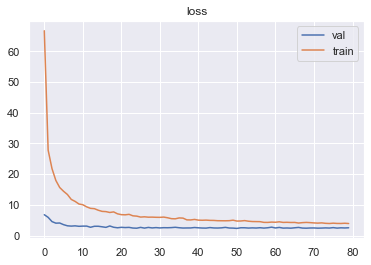

In [15]:
import matplotlib.pyplot as plt
plt.plot(vall,label='val')
plt.plot(trl,label='train')
plt.legend()
plt.title('loss')

In [32]:
vall

[11.400879357956,
 13.581956744688796,
 12.546932196477428,
 14.548767038213555,
 11.975597213197034,
 12.002720617703744,
 10.600452343554934,
 9.413485810364364,
 11.728474826726597,
 10.704889101718436]

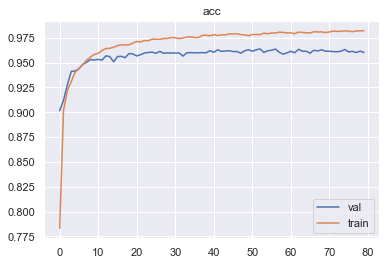

In [16]:
plt.plot(vala,label='val')
plt.plot(tra,label='train')
plt.title('acc')
plt.legend()

In [34]:
tra

[tensor(0.9857, device='cuda:0'),
 tensor(0.9864, device='cuda:0'),
 tensor(0.9861, device='cuda:0'),
 tensor(0.9856, device='cuda:0'),
 tensor(0.9869, device='cuda:0'),
 tensor(0.9871, device='cuda:0'),
 tensor(0.9874, device='cuda:0'),
 tensor(0.9884, device='cuda:0'),
 tensor(0.9880, device='cuda:0'),
 tensor(0.9887, device='cuda:0')]

In [33]:
vala

[tensor(0.9897, device='cuda:0'),
 tensor(0.9870, device='cuda:0'),
 tensor(0.9893, device='cuda:0'),
 tensor(0.9868, device='cuda:0'),
 tensor(0.9886, device='cuda:0'),
 tensor(0.9895, device='cuda:0'),
 tensor(0.9894, device='cuda:0'),
 tensor(0.9912, device='cuda:0'),
 tensor(0.9898, device='cuda:0'),
 tensor(0.9901, device='cuda:0')]

In [42]:
%%writefile train.py
import numpy as np
import torch
import os
import glob
import torchvision.transforms as transforms
import torchvision
import time
from torchvision import transforms
from torch.utils.data import Dataset
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MyNet(nn.Module):

    def __init__(self, block, layers, num_classe):
        super(MyNet, self).__init__()
        self._norm_layer = nn.BatchNorm2d

        self.inplanes = 64
        self.dilation = 1
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.downsample = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(128),
            )
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc = nn.Linear(18432, num_classe)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        ident = self.downsample(x)
        x = self.conv2(x)
        x = self.bn2(x) + ident
        x = self.relu2(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

class MyDataset(Dataset):
    def __init__(self, npy_dir,tfms=None):
        self.dir_path = npy_dir
        self.to_tensor = transforms.ToTensor()

        # all npy path
        self.npy_path = glob.glob(os.path.join(npy_dir, '*','*.npy')) 
        self.tfms = tfms
    def __getitem__(self, index):
        # load data
        single_data_path = self.npy_path[index]
        data = np.load(single_data_path, allow_pickle=True)
        
        image = data[0]
        if self.tfms:
            image = self.tfms(image)
        else:
            image = self.to_tensor(image)
        label = data[1]
       
        return (image, label)

    def __len__(self):
        return len(self.npy_path)

def train(model, train_loader, optimizer, criterion):
    epoch_loss, acc = 0, 0
    total = 0
    model.train()

    for i, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)

        out = model(image)
        if i ==0:
            print(image.shape)
            print(label.shape)
            print(out.shape)
        loss = criterion(out, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, pred = torch.max(out.data, 1)
        acc += (pred==label).sum()
        epoch_loss += loss.item()
        total += float(len(image))

    return epoch_loss, acc /total

def valid(model, data_loader, criterion):
    epoch_loss, acc = 0, 0
    total = 0
    model.eval()

    with torch.no_grad():
        for i, (image, label) in enumerate(data_loader):
            image = image.to(device)
            label = label.to(device)

            out = model(image)
            loss = criterion(out, label)
            _, pred = torch.max(out.data, 1)
            acc += (pred==label).sum()
            epoch_loss += loss.item()
            total += float(len(image))

    return epoch_loss, acc /total
tfm = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5), (0.497))])
# load dataset 
train_data = MyDataset("./Font_npy_90_train",tfm)
# valid_data = MyDataset("./Font_npy_90_train",tfm)

#####

# define dataloader
batch_size = 1024
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,                                 
                                           num_workers=2,
                                           shuffle=True)

# valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
#                                            batch_size=128,
#                                            num_workers=2,
#                                            )

model = MyNet(_,_,52)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

################
num_epochs = 10
best_valid_loss = float('inf')
best_epoch = 0

trl = []
tra = []
vall =[]
vala = []
start = time.time()
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
#     valid_loss, valid_acc = valid(model,valid_loader, criterion)
#     print(train_loss,train_acc,valid_loss,valid_acc)
#     trl.append(train_loss)
#     tra.append(train_acc)
#     vall.append(valid_loss)
#     vala.append(valid_acc)
    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     best_epoch = epoch
    #     torch.save(model.state_dict(), "./epoch_{}.pth".format(epoch))
end = time.time()  
torch.save(model.state_dict(), "./20140269.pth")
print(end-start)

Overwriting train.py


In [3]:
# %%writefile test.py
import numpy as np
import torch
import os
import glob
import torchvision.transforms as transforms
import torchvision
import time
from torchvision import transforms
from torch.utils.data import Dataset
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MyNet(nn.Module):

    def __init__(self, block, layers, num_classe):
        super(MyNet, self).__init__()
        self._norm_layer = nn.BatchNorm2d

        self.inplanes = 64
        self.dilation = 1
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.downsample = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(128),
            )
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc = nn.Linear(18432, num_classe)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        ident = self.downsample(x)
        x = self.conv2(x)
        x = self.bn2(x) + ident
        x = self.relu2(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

class MyDataset(Dataset):
    def __init__(self, npy_dir,tfms=None):
        self.dir_path = npy_dir
        self.to_tensor = transforms.ToTensor()

        # all npy path
        self.npy_path = glob.glob(os.path.join(npy_dir, '*','*.npy')) 
        self.tfms = tfms
    def __getitem__(self, index):
        # load data
        single_data_path = self.npy_path[index]
        data = np.load(single_data_path, allow_pickle=True)
        
        image = data[0]
        if self.tfms:
            image = self.tfms(image)
        else:
            image = self.to_tensor(image)
        label = data[1]
       
        return (image, label)

    def __len__(self):
        return len(self.npy_path)

def valid(model, data_loader, criterion):
    epoch_loss, acc = 0, 0
    total = 0
    model.eval()

    with torch.no_grad():
        for i, (image, label) in enumerate(data_loader):
            image = image.to(device)
            label = label.to(device)

            out = model(image)
            loss = criterion(out, label)
            _, pred = torch.max(out.data, 1)
            acc += (pred==label).sum()
            epoch_loss += loss.item()
            total += float(len(image))

    return epoch_loss, acc /total
tfm = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5), (0.497))])

valid_data = MyDataset("./Font_npy_90_val",tfm)

#####

valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size=128,
                                           )

model = MyNet(_,_,52)
model.load_state_dict(torch.load('./20140269.pth'))
model.to(device)
criterion = nn.CrossEntropyLoss()
valid_loss, valid_acc = valid(model,valid_loader, criterion)
valid_acc

tensor(0.9397, device='cuda:0')

In [44]:
class Block(nn.Module):
    def __init__(self, inplanes, planes, stride):
        super(Block, self).__init__()
        norm_layer = nn.BatchNorm2d
        self.conv1 =  nn.Conv2d(inplanes, planes, kernel_size=3,stride=stride,bias=False,padding=1)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if stride != 1 or inplanes != planes:
            self.downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False),
                norm_layer(planes),
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out
    
class MyNet(nn.Module):

    def __init__(self, block, layers, num_classe):
        super(MyNet, self).__init__()
        self._norm_layer = nn.BatchNorm2d

        self.dilation = 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, stride=2, padding=3,
                               bias=False)
        
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.downsample = nn.Sequential(
                nn.Conv2d(16, 32, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(32),
            )
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc = nn.Linear(4608, num_classe)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        ident = self.downsample(x)
        x = self.conv2(x)
        x = self.bn2(x) + ident
        x = self.relu2(x)
        x = torch.flatten(x, 1)
#         print(x.shape)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)
# Epoch[9/10], Train Loss:7.9414, Train Acc:0.95
# 2.328733094036579 tensor(0.9246, device='cuda:0')
# torch.Size([1024, 1, 90, 90])
# torch.Size([1024])
# torch.Size([1024, 52])
# 100%|██████████| 10/10 [04:35<00:00, 27.57s/it]
# Epoch[10/10], Train Loss:7.3846, Train Acc:0.95
# 2.2121686339378357 tensor(0.9281, device='cuda:0')

20140269.pth.pth
4李④낵�젣.docx
Font_npy_90_train
Font_npy_90_train.zip
Font_npy_90_val
Font_npy_90_val.zip
last_怨쇱젣.ipynb
model.pth
test.py
train.py
~$4李④낵�젣.docx
~WRL0532.tmp


In [ ]:
class Block(nn.Module):
    def __init__(self, inplanes, planes, stride):
        super(Block, self).__init__()
        norm_layer = nn.BatchNorm2d
        self.conv1 =  nn.Conv2d(inplanes, planes, kernel_size=3,stride=stride,bias=False,padding=1)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if stride != 1 or inplanes != planes:
            self.downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False),
                norm_layer(planes),
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out
    
class MyNet(nn.Module):

    def __init__(self, block, layers, num_classe):
        super(MyNet, self).__init__()
        self._norm_layer = nn.BatchNorm2d

        self.dilation = 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=7, stride=2, padding=3,
                               bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.downsample = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(64),
            )
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout = nnDropout(0.5),
        self.fc = nn.Linear(9216, num_classe)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        ident = self.downsample(x)
        x = self.conv2(x)
        x = self.bn2(x) + ident
        x = self.relu2(x)
        x = torch.flatten(x, 1)
#         print(x.shape)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)
# Epoch[23/40], Train Loss:1.6554, Train Acc:0.99
# 1.780292920768261 tensor(0.9538, device='cuda:0')

In [ ]:
class MyNet(nn.Module):

    def __init__(self, block, layers, num_classe):
        super(MyNet, self).__init__()
        self._norm_layer = nn.BatchNorm2d

        self.dilation = 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=7, stride=2, padding=3,
                               bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        
        self.downsample1 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(64),
            )
        self.downsample2 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(128),
            )
                
#         self.dropout = nnDropout(0.3),
        self.fc = nn.Linear(4608, num_classe)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        ident = self.downsample1(x)
        x = self.conv2(x)
        x = self.bn2(x) + ident
        x = self.relu2(x)
        ident = self.downsample2(x)
        x = self.conv3(x)
        x = self.bn3(x) + ident
        x = self.relu3(x)
        x = torch.flatten(x, 1)
#         print(x.shape)
#         x = self.dropout(x)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)
# Epoch[31/40], Train Loss:1.5932, Train Acc:0.99
# 1.2462433874607086 tensor(0.9590, device='cuda:0')

In [ ]:
class MyNet(nn.Module):

    def __init__(self, block, layers, num_classe):
        super(MyNet, self).__init__()
        self._norm_layer = nn.BatchNorm2d

        self.dilation = 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=7, stride=2, padding=3,
                               bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        
        self.downsample1 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(64),
            )
        self.downsample2 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(128),
            )
        self.downsample3 = nn.Sequential(
                nn.Conv2d(128, 256, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(256),
            )
                
#         self.dropout = nnDropout(0.3),
        self.fc = nn.Linear(2304, num_classe)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        ident = self.downsample1(x)
        x = self.conv2(x)
        x = self.bn2(x) + ident
        x = self.relu2(x)
        ident = self.downsample2(x)
        x = self.conv3(x)
        x = self.bn3(x) + ident
        x = self.relu3(x)
        
        ident = self.downsample3(x)
        x = self.conv4(x)
        x = self.bn4(x) + ident
        x = self.relu4(x)        
        
        x = torch.flatten(x, 1)
#         print(x.shape)
#         x = self.dropout(x)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)
# Epoch[28/40], Train Loss:1.7391, Train Acc:0.98
# 1.2742572948336601 tensor(0.9582, device='cuda:0')


In [ ]:
class MyNet(nn.Module):

    def __init__(self, block, layers, num_classe):
        super(MyNet, self).__init__()
        self._norm_layer = nn.BatchNorm2d

        self.dilation = 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=7, stride=2, padding=3,
                               bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)

        
        self.downsample1 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(64),
            )
        self.downsample2 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(128),
            )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(4608, num_classe)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        ident = self.downsample1(x)
        x = self.conv2(x)
        x = self.bn2(x) + ident
        x = self.relu2(x)
        ident = self.downsample2(x)
        x = self.conv3(x)
        x = self.bn3(x) + ident
        x = self.relu3(x)
        
        x = torch.flatten(x,1)
#         print(x.shape)
        x = self.dropout(x)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)
# Epoch[40/40], Train Loss:2.6018, Train Acc:0.98
# 1.3340800106525421 tensor(0.9581, device='cuda:0')

In [ ]:
class MyNet(nn.Module):

    def __init__(self, block, layers, num_classe):
        super(MyNet, self).__init__()
        self._norm_layer = nn.BatchNorm2d

        self.dilation = 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=7, stride=2, padding=3,
                               bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)

        
        self.downsample1 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(64),
            )
        self.downsample2 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(128),
            )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(4608, num_classe)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        ident = self.downsample1(x)
        x = self.conv2(x)
        x = self.bn2(x) + ident
        x = self.relu2(x)
        ident = self.downsample2(x)
        x = self.conv3(x)
        x = self.bn3(x) + ident
        x = self.relu3(x)
        
        x = torch.flatten(x,1)
#         print(x.shape)
        x = self.dropout(x)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)
# Epoch[39/40], Train Loss:1.8657, Train Acc:0.98
# 1.3427405655384064 tensor(0.9606, device='cuda:0')
# torch.Size([1024, 1, 90, 90])

In [ ]:
# adam weight decay


# Epoch[27/50], Train Loss:1.9248, Train Acc:0.98
# 1.3467636704444885 tensor(0.9604, device='cuda:0')
# torch.Size([1024, 1, 90, 90])
# torch.Size([1024])
# torch.Size([1024, 52])

In [ ]:
'''
모델 with 0.001
Epoch[5/5], Train Loss:8.7186, Train Acc:0.94
2.086592584848404 tensor(0.9347, device='cuda:0')

모델 with 0.0005

Train Acc:0.92
valid acc : 0.92

model with 0.005
Epoch[5/20], Train Loss:9.8456, Train Acc:0.93
2.388212338089943 tensor(0.9238, device='cuda:0')


model with 0.002
Epoch[5/20], Train Loss:8.0757, Train Acc:0.94
2.0057855620980263 tensor(0.9368, device='cuda:0')

model with 0.003
Epoch[5/20], Train Loss:8.6232, Train Acc:0.94
2.1346734762191772 tensor(0.9329, device='cuda:0')

'''

In [ ]:
'''
경량화 -> resnet 1,1 : 27->42초로 늘어남 epoch당
10분에 94까지밖에 못감
'''

'''
16부터 lr 조절?

'''